> This notebook is trying to use [A Million News Headlines](https://www.kaggle.com/therohk/million-headlines) dataset to implement a fake news headlines detection model using machine learning approach. Where the A Million News Headlines dataset will be labeled as real news headlines. And this notebook will also use two fake news headline datasets on Kaggle from [Fake and real news](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset) and [Getting Real about Fake News](https://www.kaggle.com/mrisdal/fake-news) . 



In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# **Load Datasets**

In [2]:
#Read Dataset
Headlines = pd.read_csv('dataset/abcnews-date-text.csv', usecols =["headline_text"]).dropna()
Headlines1 = pd.read_csv('dataset/fake.csv', usecols =["title"]).dropna()
# Headlines2 = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv', usecols =["title"]).dropna()

In [3]:
#Removing duplicated headlines
Headlines = Headlines.drop_duplicates('headline_text')
Headlines1 = Headlines1.drop_duplicates('title')
# Headlines2 = Headlines2.drop_duplicates('title')

In [4]:
#Rename dataframe columns and Combine all datasets
Headlines1 = Headlines1.rename(columns={'title': 'headline_text'})
# Headlines2 = Headlines2.rename(columns={'title': 'headline_text'})

# **Labelling**

In [5]:
#Creating lable for datasets
#million-headlines dataset will be used as real headlines
#fake-and-real-news-dataset & fake-news dataset will be used as fake headlines
Headlines['fake'] = 0
Headlines1['fake'] = 1
# Headlines2['fake'] = 1

# **Combine Datasets**

In [6]:
#Downsize million-headlines dataset to first 50K rows
data = pd.concat([Headlines[:50000],Headlines1])
print('Training dataset contains: {} Real headlines and {} Fake headlines.'.format(50000,len(Headlines1)))
data.to_csv('Combined_headlines.csv', index=False)

Training dataset contains: 50000 Real headlines and 11698 Fake headlines.


# **Data Preprocessing**

In [7]:
import gensim
import nltk as nl
nl.download("stopwords", download_dir='./nltk_data')
nl.download("punkt", download_dir='./nltk_data')
from sklearn.feature_extraction import text


nltk_stopwords = nl.corpus.stopwords.words('english')
gensim_stopwords = gensim.parsing.preprocessing.STOPWORDS
sklearn_stopwords = text.ENGLISH_STOP_WORDS
combined_stopwords = sklearn_stopwords.union(nltk_stopwords,gensim_stopwords)

[nltk_data] Downloading package stopwords to ./nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to ./nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
print('NLTK has {} stop words'.format(len(nltk_stopwords)))
print('Gensim has {} stop words'.format(len(gensim_stopwords)))
print('Sklearn has {} stop words'.format(len(sklearn_stopwords)))
print('Combined stopwords list has {} stop words'.format(len(combined_stopwords)))

NLTK has 179 stop words
Gensim has 337 stop words
Sklearn has 318 stop words
Combined stopwords list has 390 stop words


In [9]:
from nltk.stem import PorterStemmer 
porter_stemmer = PorterStemmer() 

In [10]:
data['headline_text'] = data['headline_text'].apply(lambda x: x.lower())
data['headline_text'] = data['headline_text'].apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))
data['headline_text'] = data['headline_text'].apply(lambda x: ' '.join([porter_stemmer.stem(word) for word in x.split()]))
data['headline_text'] = data['headline_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (combined_stopwords)]))

# **Splitting Dataset**

In [11]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(data['headline_text'], data['fake'], test_size=0.2, random_state=7)

# **Construct models with TF-IDF**

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv1D, MaxPooling1D, Flatten, Embedding, GlobalMaxPooling1D
# from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [13]:
tfidf_vectorizer = TfidfVectorizer(tokenizer = word_tokenize, max_features = 300)
tfidf_train = tfidf_vectorizer.fit_transform(x_train)
tfidf_test = tfidf_vectorizer.transform(x_test)
tfidf_combine = np.vstack([tfidf_train.todense(), tfidf_test.todense()])
tfidf_features = tfidf_vectorizer.get_feature_names_out()

c:\Users\Oscar Yu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


# **1.1 Different Basic Model Overview**

**1.Decision Tree**

In [14]:
from sklearn.metrics import accuracy_score
dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_model.fit(tfidf_train, y_train)
y_pred_dt = dt_model.predict(tfidf_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Accuracy of the Decision Tree model: {accuracy_dt * 100:.2f}%")

Accuracy of the Decision Tree model: 85.21%


**2.Random Forest Classifier**

In [15]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
rf_model.fit(tfidf_train, y_train)
y_pred_rf = rf_model.predict(tfidf_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy of the Random Forest model: {accuracy_rf * 100:.2f}%")

Accuracy of the Random Forest model: 81.27%


**3.k-Nearest Neighbors (kNN)**

In [16]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(tfidf_train, y_train)
y_pred = knn_model.predict(tfidf_test)
accuracy_kNN = accuracy_score(y_test, y_pred)
print(f"Accuracy of the kNN model: {accuracy_kNN * 100:.2f}%")

Accuracy of the kNN model: 80.23%


**4.Support Vector Classifier (SVC)**

In [17]:
from sklearn.svm import SVC
svc_model = SVC(kernel='linear', C=1, random_state=42)
svc_model.fit(tfidf_train, y_train)
y_pred = svc_model.predict(tfidf_test)
accuracy_SVC = accuracy_score(y_test, y_pred)
print(f"Accuracy of the SVC model: {accuracy_SVC * 100:.2f}%")

Accuracy of the SVC model: 87.63%


**5.Naive Bayesiian Model**

In [18]:
nb_model = MultinomialNB()
nb_model.fit(tfidf_train, y_train)
y_pred = nb_model.predict(tfidf_test)
accuracy_nb = accuracy_score(y_test, y_pred)
print(f"Accuracy of the Naive Bayes model: {accuracy_nb * 100:.2f}%")


Accuracy of the Naive Bayes model: 88.03%


**6.Logistic Regression Model**

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Logistic Regression Model
log_reg = LogisticRegression(C=1.0, penalty='none', solver='newton-cg', random_state=42)

# Train the model
log_reg.fit(tfidf_train, y_train)

# Predict on the test set
y_pred = log_reg.predict(tfidf_test)

# Evaluate the model
accuracy_log = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_log:.2f}")
print(classification_report(y_test, y_pred))

c:\Users\Oscar Yu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Accuracy: 0.88
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      9997
           1       0.87      0.44      0.58      2343

    accuracy                           0.88     12340
   macro avg       0.87      0.71      0.76     12340
weighted avg       0.88      0.88      0.86     12340



**Basic Model Performance Summary**

In [20]:
print("\nModel Performance Summary:")
print(f"{'Model':<20} {'Accuracy':>10}")
print("-" * 30)
print(f"{'Decision Tree:':<25}{accuracy_dt * 100:.2f}%")
print(f"{'Random Forest:':<24} {accuracy_rf * 100:.2f}%")
print(f"{'kNN:':<24} {accuracy_kNN * 100:.2f}%")
print(f"{'SVC:':<24} {accuracy_SVC * 100:.2f}%")
print(f"{'Naive Bayes:':<24} {accuracy_nb * 100:.2f}%")
print(f"{'Logistic Regression:':<24} {accuracy_log * 100:.2f}%")


Model Performance Summary:
Model                  Accuracy
------------------------------
Decision Tree:           85.21%
Random Forest:           81.27%
kNN:                     80.23%
SVC:                     87.63%
Naive Bayes:             88.03%
Logistic Regression:     88.03%


# **1.2Random Sampling from TFIDF_train (with label) set with different models**

In [21]:
# Split n sets of label-balanced data
def get_random_sample_sets(df, n=100, k=5000):
    def find_news(label):
        df_found = df[df["fake"] == label]
        df_sample = df_found.sample(k)
        return df_sample

    def random_samples():
        true_news = find_news(0)
        fake_news = find_news(1)
        concat_df = pd.concat((true_news, fake_news), axis=0)
        
        # Shuffle only once before splitting
        shuffled_df = concat_df.sample(frac=1)
        
        return shuffled_df

    random_sample_sets = [random_samples() for _ in range(n)]
    return random_sample_sets

# Base method for bagging model
def train_model(base_model, sample_set: pd.DataFrame):

    Y = sample_set["fake"]
    X = sample_set.drop("fake", axis=1)

    base_model.fit(X, Y)
    return base_model

def bagging_pred(model_set, test_set: pd.DataFrame):

    def model_pred(model, test_set: pd.DataFrame):
        y_pred = model.predict(test_set)
        return y_pred
    
    def vote(row: pd.Series):
        vote_result = row.mode()
        return vote_result

    Y = test_set["fake"]
    X = test_set.drop("fake", axis=1)

    predictions = []
    # Collect predictions in a list. Iterated by models
    for k in range(len(model_set)):
        pred = model_pred(model_set[k], X)
        predictions.append(pred)

    pred_result = pd.DataFrame(predictions)

    # Apply the voting function to each row
    vote_result = pred_result.apply(vote, axis=0).iloc[0]
    score = accuracy_score(Y, vote_result)
    return score

Prepare Balanced Samples and Base Model

In [22]:
population_set = pd.concat((pd.DataFrame(tfidf_combine), pd.concat((y_train, y_test)).reset_index(drop=True)), axis=1)
random_sample_set = get_random_sample_sets(population_set, 1, 11000)

dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=5)
svc_model = SVC(kernel='linear', C=1, random_state=42)
nb_model = MultinomialNB()
lr_model = LogisticRegression(C=1.0, penalty='none', solver='newton-cg', random_state=42)

Evaluate model performance with balanced dataset by cross-validation

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      9952
           1       1.00      0.22      0.36      2388

    accuracy                           0.85     12340
   macro avg       0.92      0.61      0.64     12340
weighted avg       0.87      0.85      0.81     12340



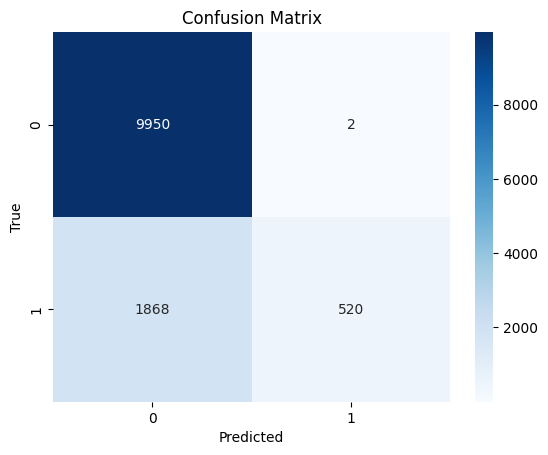

              precision    recall  f1-score   support

           0       0.56      1.00      0.72      2193
           1       1.00      0.22      0.36      2207

    accuracy                           0.61      4400
   macro avg       0.78      0.61      0.54      4400
weighted avg       0.78      0.61      0.54      4400



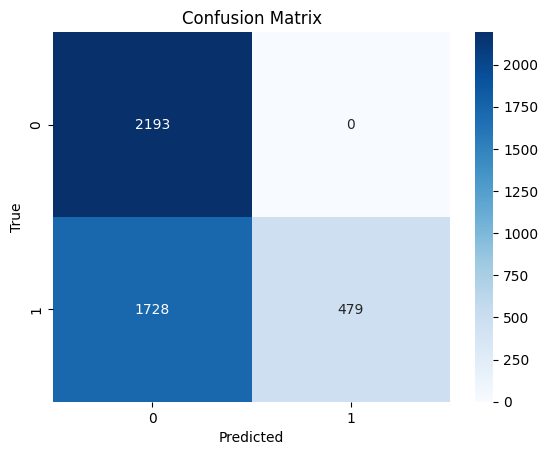

In [23]:
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

def cross_validation_balance(df):

    Y = random_sample_set[0]["fake"]
    X = random_sample_set[0].drop("fake",axis=1)

    dt_accuracy = cross_val_score(dt_model, X, Y, cv=5, scoring="accuracy")
    rf_accuracy = cross_val_score(rf_model, X, Y, cv=5, scoring="accuracy")
    knn_accuracy = cross_val_score(knn_model, X, Y, cv=5, scoring="accuracy")
    svc_accuracy = cross_val_score(svc_model, X, Y, cv=5, scoring="accuracy")
    nb_accuracy = cross_val_score(nb_model, X, Y, cv=5, scoring="accuracy")
    lr_accuracy = cross_val_score(lr_model, X, Y, cv=5, scoring="accuracy")
    print(f"Cross-validation scores: {dt_accuracy}")
    print(f"Average cross-validation score: {np.mean(dt_accuracy)}")

    print("\nModel Average Performance Summary:")
    print(f"{'Model':<20} {'Accuracy':>10}")
    print("-" * 30)
    print(f"{'Decision Tree:':<25}{np.mean(dt_accuracy) * 100:.2f}%")
    print(f"{'Random Forest:':<24} {np.mean(rf_accuracy) * 100:.2f}%")
    print(f"{'kNN:':<24} {np.mean(knn_accuracy) * 100:.2f}%")
    print(f"{'SVC:':<24} {np.mean(svc_accuracy) * 100:.2f}%")
    print(f"{'Naive Bayes:':<24} {np.mean(nb_accuracy) * 100:.2f}%")
    print(f"{'Logistic Regression:':<24} {np.mean(lr_accuracy) * 100:.2f}%")

def confusion_predict(model, df):

    # df: balanced df set
    Y = df["fake"]
    X = df.drop("fake",axis=1)

    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    # Print classification report
    print(classification_report(y_test, y_pred))  # Corrected to use y_test

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

confusion_predict(dt_model, population_set)
confusion_predict(dt_model, random_sample_set[0])

#**Re- Dataset Split**

In [30]:
df = random_sample_set[0]
Y = df["fake"]
X = df.drop("fake",axis=1)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)


# **2.1 Create a confusion matrix graph with PCA and logistic Regression**

              precision    recall  f1-score   support

           0       0.67      0.91      0.77      2193
           1       0.86      0.56      0.68      2207

    accuracy                           0.73      4400
   macro avg       0.77      0.73      0.73      4400
weighted avg       0.77      0.73      0.73      4400



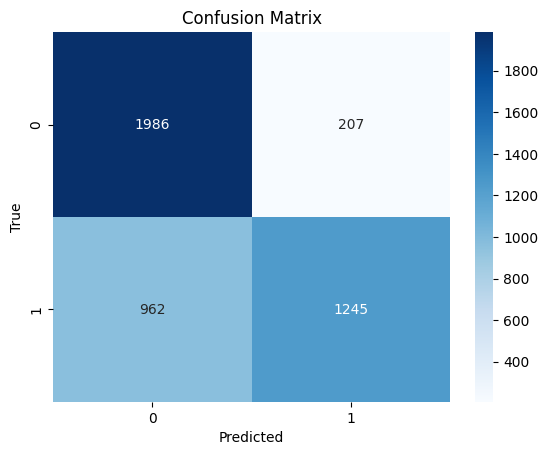

Cross-validation scores: [0.74147727 0.73039773 0.72727273 0.73068182 0.74090909]
Average cross-validation score: 0.7341477272727273


In [35]:
# Create a pipeline with PCA and logistic regression
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix


# Convert sparse matrix to dense array
tfidf_train_dense = tfidf_train.toarray()
tfidf_test_dense = tfidf_test.toarray()
# Define the pipeline
pipeline = Pipeline([
    ('pca', PCA(n_components=100)),  # Adjust n_components based on your data
    ('logistic_regression', LogisticRegression(random_state=42))
])

# Fit the pipeline
pipeline.fit(x_train, y_train)

# Predict on the test set
predictions = pipeline.predict(x_test)

# Print classification report
print(classification_report(y_test, predictions))  # Corrected to use y_test

# Plot confusion matrix
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Perform 5-fold cross-validation
scores = cross_val_score(pipeline, x_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {scores}")
print(f"Average cross-validation score: {np.mean(scores)}")

*Create a pipeline with PCA and Logistic Regression* 

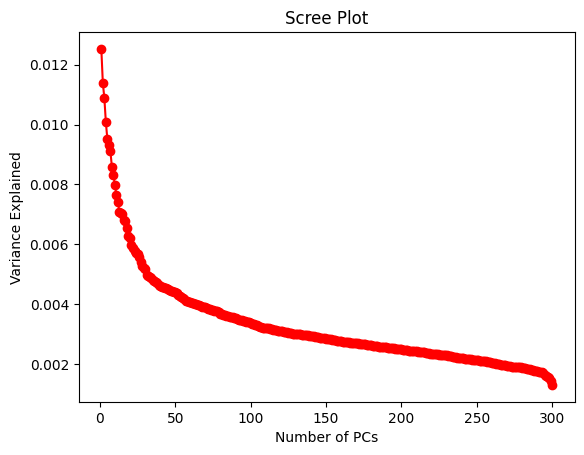

In [25]:
# Create a pipeline with PCA and logistic regression
pc_num = 300

pipe = Pipeline([
    ('pca', PCA(n_components = pc_num)), # choose number of components to keep
    ('clf', LogisticRegression(solver = 'liblinear', class_weight = 'balanced', max_iter = 500, penalty = 'l1'))
])

pipe.fit(x_train, y_train)

# Create a scree plota
plt.plot(np.arange(1, pipe.named_steps['pca'].n_components_+1),pipe.named_steps['pca'].explained_variance_ratio_, 'ro-')
plt.xlabel('Number of PCs')
plt.ylabel('Variance Explained')
plt.title('Scree Plot')
plt.show()

# **2.2 Logistic Regression with Lasso**

In [36]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf_lasso = LogisticRegression(C=0.1, class_weight='balanced', penalty='l1', solver='liblinear', random_state=42)
log_clf_lasso.fit(x_train, y_train)
# Corrected instantiation using keyword arguments
""" lasso_RFE_selector = RFE(estimator=log_clf_lasso, n_features_to_select=30)

lasso_RFE_selector.fit(tfidf_train, y_train) """

# Assuming you meant to use cross_val_score with the selector
scores = cross_val_score(log_clf_lasso, x_train, y_train, cv=5)

print("Cross-validation scores:", scores)
print("Average cross-validation score:", scores.mean())


Cross-validation scores: [0.73352273 0.72585227 0.71534091 0.72443182 0.73096591]
Average cross-validation score: 0.7260227272727273


# **2.3 Logistic Regression Classifier- Randomized Search**

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, loguniform

# Define the hyperparameter distributions for logistic regression
param_dist = {
    'C': uniform(0.001, 999),  # Uniform distribution between 0.001 and 1000
    'penalty': ['l1', 'l2'],  # Lasso or Ridge regularization
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # Algorithm to use in the optimization problem
    'max_iter': randint(10, 100),  # Discrete integer distribution for max_iter
    'class_weight': ['balanced', None]  # Class weights
}

# Initialize the Logistic Regression model
lr = LogisticRegression(random_state=42)

# Set up RandomizedSearchCV for logistic regression
rand_search_lr = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings that are sampled
    cv=5,  # Number of cross-validation folds
    verbose=2,  # Controls the verbosity: the higher, the more messages
    random_state=42,  # For reproducibility
    n_jobs=-1  # Use all processors
)

# Fit the model to the data
rand_search_lr.fit(x_train, y_train)

# Access the best model and its hyperparameters
best_lr = rand_search_lr.best_estimator_
print('Best hyperparameters:', rand_search_lr.best_params_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


KeyboardInterrupt: 

# **2.5 RandomForest Classifier- Grid Search**

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report



param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Regularization parameter
    'penalty': ['l1', 'l2'],  # Lasso or Ridge regularization
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # Optimization algorithm
    'max_iter': [100, 200, 300]  # Maximum number of iterations
}

# Step 4: Initialize GridSearchCV with the Logistic Regression model and the parameter grid
log_reg = LogisticRegression(random_state=42)
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Step 5: Fit the GridSearchCV object to the training data
grid_search.fit(x_train, y_train)

# Step 6: Retrieve the best parameters and evaluate the model on the test set
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Predict on the test set
y_pred = grid_search.predict(x_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 210 candidates, totalling 1050 fits


KeyboardInterrupt: 

# **3.1 RandomForest Classifier- Basic Model**

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(tfidf_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(tfidf_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))


Accuracy: 0.88
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      9997
           1       0.83      0.46      0.60      2343

    accuracy                           0.88     12340
   macro avg       0.86      0.72      0.76     12340
weighted avg       0.88      0.88      0.87     12340



# **3.2 RandomForest Classifier- Randomized Search**

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the hyperparameter distributions for logistic regression
param_dist = {
    'C': randint(0.001, 1000),  # Inverse of regularization strength
    'penalty': ['l1', 'l2'],  # Lasso or Ridge regularization
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # Algorithm to use in the optimization problem
    'max_iter': randint(10, 100),  # Maximum number of iterations
    'class_weight': ['balanced', None]  # Class weights
}

# Initialize the Logistic Regression model
lr = LogisticRegression(random_state=42)

# Set up RandomizedSearchCV for logistic regression
rand_search_lr = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings that are sampled
    cv=5,  # Number of cross-validation folds
    verbose=2,  # Controls the verbosity: the higher, the more messages
    random_state=42,  # For reproducibility
    n_jobs=-1  # Use all processors
)

# Fit the model to the data
rand_search_lr.fit(tfidf_train, y_train)

# Access the best model and its hyperparameters
best_lr = rand_search_lr.best_estimator_
print('Best hyperparameters:', rand_search_lr.best_params_)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the hyperparameter distributions for logistic regression
param_dist = {
    'C': randint(0.001, 1000),  # Inverse of regularization strength
    'penalty': ['l1', 'l2'],  # Lasso or Ridge regularization
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # Algorithm to use in the optimization problem
    'max_iter': randint(10, 100),  # Maximum number of iterations
    'class_weight': ['balanced', None]  # Class weights
}

# Initialize the Logistic Regression model
lr = LogisticRegression(random_state=42)

# Set up RandomizedSearchCV for logistic regression
rand_search_lr = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings that are sampled
    cv=5,  # Number of cross-validation folds
    verbose=2,  # Controls the verbosity: the higher, the more messages
    random_state=42,  # For reproducibility
    n_jobs=-1  # Use all processors
)

# Fit the model to the data
rand_search_lr.fit(tfidf_train, y_train)

# Access the best model and its hyperparameters
best_lr = rand_search_lr.best_estimator_
print('Best hyperparameters:', rand_search_lr.best_params_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\Oscar Yu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
90 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Oscar Yu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Oscar Yu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\Oscar Yu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklear

Best hyperparameters: {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 56}


# **3.3 RandomForest Classifier- Grid Search**

In [29]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(tfidf_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Print the best parameters
print(f"Best Parameters: {best_params}")

# Predict on the test set
y_pred = grid_search.predict(tfidf_test)

# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


KeyboardInterrupt: 